<a href="https://colab.research.google.com/github/Kubenew/ASI/blob/main/hrl9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Extended Hierarchical PPO training started...



/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


[Train] Ep   20 | R:   -12.0 | AvgR20:     9.2 | Succ: 60.00% | OptLen:  16.2 | TermProb: 0.089 | HEnt: 0.83
[Train] Ep   40 | R:    24.6 | AvgR20:    16.9 | Succ: 80.00% | OptLen:  16.7 | TermProb: 0.060 | HEnt: 0.81
[Train] Ep   60 | R:    24.7 | AvgR20:    13.3 | Succ: 70.00% | OptLen:  14.2 | TermProb: 0.037 | HEnt: 0.79
[Train] Ep   80 | R:    24.2 | AvgR20:    13.4 | Succ: 70.00% | OptLen:  19.7 | TermProb: 0.034 | HEnt: 0.76
[EVAL] Ep  100 | R:    24.2 | AvgR20:    17.2 | Succ: 80.00% | OptLen:  17.0 | TermProb: 0.022 | HEnt: 0.73
[Train] Ep  120 | R:    24.6 | AvgR20:    13.4 | Succ: 70.00% | OptLen:  19.9 | TermProb: 0.030 | HEnt: 0.70
[Train] Ep  140 | R:    23.1 | AvgR20:    16.5 | Succ: 80.00% | OptLen:  12.3 | TermProb: 0.041 | HEnt: 0.67
[Train] Ep  160 | R:   -12.0 | AvgR20:    12.9 | Succ: 70.00% | OptLen:  16.9 | TermProb: 0.021 | HEnt: 0.62
[Train] Ep  180 | R:   -12.0 | AvgR20:     6.0 | Succ: 50.00% | OptLen:  11.6 | TermProb: 0.034 | HEnt: 0.59
[EVAL] Ep  200 | R: 

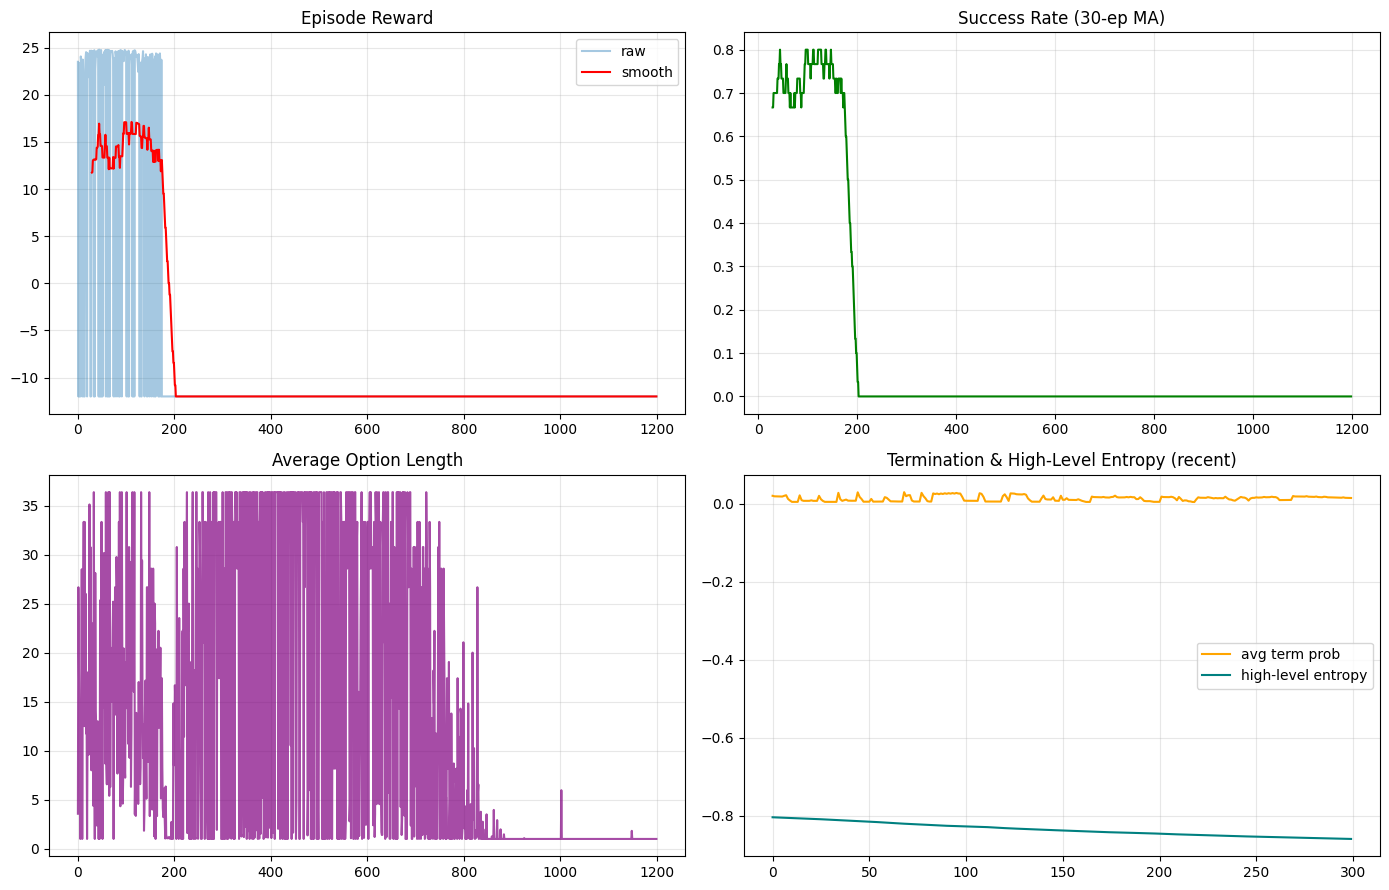


Training finished.
Final 100-ep mean reward:    -12.0
Final 100-ep success rate:   0.00%
Final avg option length:     1.0


In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import random
import warnings
from typing import List

warnings.filterwarnings("ignore", category=DeprecationWarning)

# ────────────────────────────────────────
# Hyperparameters ────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

GRID_SIZE = 10
OBSTACLE_PROB = 0.20

LR_HIGH   = 1e-4
LR_LOW    = 3e-4
LR_TERM   = 3e-4
LR_CRITIC = 3e-4

PPO_EPOCHS       = 6
PPO_BATCH_SIZE   = 64
CLIP_EPS         = 0.22
ENTROPY_COEF_LOW = 0.015
ENTROPY_COEF_HIGH = 0.02
VALUE_LOSS_COEF  = 0.6
MAX_GRAD_NORM    = 0.8

GAE_LAMBDA       = 0.95
GAMMA            = 0.99

MAX_EPISODES     = 1200
MAX_STEPS        = 500
OPTION_TIMEOUT   = 40
GOAL_RADIUS      = 1.2
SHAPE_SCALE      = 0.12
DIVERSITY_COEF   = 0.005

EVAL_EVERY       = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
# ────────────────────────────────────────

Transition = namedtuple("Transition", [
    "state", "action", "log_prob", "reward", "next_state", "done",
    "value", "subgoal", "subgoal_mu", "subgoal_std"
])

OptionTrajectory = namedtuple("OptionTrajectory", [
    "transitions", "final_value", "ep_return", "option_length", "advantages", "initial_high_level_state"
])


class ProcGenGridWorld(gym.Env):
    def __init__(self, size=GRID_SIZE, obstacle_prob=OBSTACLE_PROB):
        super().__init__()
        self.size = size
        self.obstacle_prob = obstacle_prob
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(
            low=np.zeros(4), high=np.full(4, size-1), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.grid = np.zeros((self.size, self.size), dtype=np.float32)
        for i in range(self.size):
            for j in range(self.size):
                if random.random() < self.obstacle_prob:
                    self.grid[i, j] = 1.0

        self.agent_pos = np.array([0.0, 0.0])
        self.goal_pos = np.array([float(self.size-1), float(self.size-1)])
        self.grid[0, 0] = 0
        self.grid[self.size-1, self.size-1] = 0

        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return np.concatenate([self.agent_pos, self.goal_pos]).astype(np.float32)

    def step(self, action):
        self.steps += 1
        moves = np.array([[-1,0],[1,0],[0,-1],[0,1]])
        delta = moves[action]
        new_pos = np.clip(self.agent_pos + delta, 0, self.size-1)

        if self.grid[int(new_pos[0]), int(new_pos[1])] == 0:
            self.agent_pos = new_pos

        dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        reward = -0.01
        terminated = dist < 0.6
        truncated = self.steps >= 400
        success = False

        if terminated:
            reward += 25.0
            success = True
        elif truncated:
            reward -= 8.0

        return self._get_obs(), reward, terminated, truncated, {"success": success}


class HighLevelPolicy(nn.Module):
    def __init__(self, state_dim=4, subgoal_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 96),
            nn.Tanh(),
            nn.Linear(96, 64),
            nn.Tanh(),
        )
        self.mu_head  = nn.Linear(64, subgoal_dim)
        self.log_std  = nn.Parameter(torch.full((subgoal_dim,), -1.0))
        self.value_head = nn.Linear(64, 1)

    def forward(self, state):
        feat = self.net(state)
        mu = self.mu_head(feat)
        std = torch.exp(self.log_std.clamp(-20, 2))
        value = self.value_head(feat)
        return mu, std, value


class LowLevelActorCritic(nn.Module):
    def __init__(self, input_dim=6, n_actions=4):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
        )
        self.actor = nn.Linear(128, n_actions)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        feat = self.trunk(x)
        logits = self.actor(feat)
        value = self.critic(feat)
        return logits, value


class TerminationNet(nn.Module):
    def __init__(self, input_dim=4):  # FIXED: pos(2) + subgoal(2) = 4
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.net(x))


def compute_gae(rewards: List[float], values: List[float], next_value: float, dones: List[float]):
    advantages = []
    gae = 0.0
    values = values + [next_value]
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + GAMMA * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + GAMMA * GAE_LAMBDA * (1 - dones[step]) * gae
        advantages.insert(0, gae)
    return advantages


def select_subgoal(mu, std, deterministic=False):
    if deterministic:
        return mu
    dist = Normal(mu, std)
    return dist.sample()


def train_extended_hierarchical_ppo():
    env = ProcGenGridWorld()

    high_policy = HighLevelPolicy().to(DEVICE)
    low_ac = LowLevelActorCritic(input_dim=6).to(DEVICE)
    term_net = TerminationNet(input_dim=4).to(DEVICE)  # FIXED: pass input_dim explicitly

    opt_high = optim.Adam(high_policy.parameters(), lr=LR_HIGH)
    opt_low = optim.Adam(low_ac.parameters(), lr=LR_LOW)
    opt_term = optim.Adam(term_net.parameters(), lr=LR_TERM)

    reward_hist = []
    success_hist = []
    option_len_hist = []
    term_prob_hist = []
    high_ent_hist = []

    print("Extended Hierarchical PPO training started...\n")

    for ep in range(1, MAX_EPISODES + 1):
        deterministic = (ep % EVAL_EVERY == 0)
        state, _ = env.reset(seed=SEED + ep)
        state_t = torch.FloatTensor(state).to(DEVICE)

        ep_reward = 0.0
        ep_success = False
        total_steps = 0
        option_trajectories = []

        done = False
        while not done and total_steps < MAX_STEPS:
            current_high_level_state = state_t.clone() # Capture the state before option execution
            # High-level decision
            with torch.no_grad():
                mu, std, high_value = high_policy(current_high_level_state.unsqueeze(0))
            subgoal_cont = select_subgoal(mu, std, deterministic).squeeze(0)
            subgoal_disc = torch.clamp(torch.round(subgoal_cont), 0, GRID_SIZE-1).float()

            # Low-level rollout
            option_trans = []
            option_steps = 0
            option_done = False
            option_rewards = []
            option_values = []
            option_dones = []

            while not done and not option_done and option_steps < OPTION_TIMEOUT:
                pos_t = state_t[:2]
                goal_t = state_t[2:]
                inp = torch.cat([pos_t, subgoal_disc, goal_t]).unsqueeze(0)

                logits, value = low_ac(inp)
                dist = Categorical(logits=logits.squeeze(0))
                action = dist.sample()
                log_prob = dist.log_prob(action)

                act = action.item()
                next_state, rew, term, trunc, info = env.step(act)
                done = term or trunc
                next_state_t = torch.FloatTensor(next_state).to(DEVICE)

                shaped_rew = -SHAPE_SCALE * torch.norm(next_state_t[:2] - subgoal_disc).item()
                total_rew = rew + shaped_rew

                dist_to_sub = np.linalg.norm(next_state[:2] - subgoal_disc.cpu().numpy())
                should_term = (dist_to_sub < GOAL_RADIUS) or done
                term_label = 1.0 if should_term else 0.0

                option_trans.append(Transition(
                    state=inp.squeeze(0).cpu().numpy(),
                    action=act,
                    log_prob=log_prob.item(),
                    reward=total_rew,
                    next_state=next_state,
                    done=float(done),
                    value=value.item(),
                    subgoal=subgoal_disc.cpu().numpy(),
                    subgoal_mu=mu.squeeze(0).cpu().numpy(),
                    subgoal_std=std.squeeze(0).cpu().numpy(),
                ))

                option_rewards.append(total_rew)
                option_values.append(value.item())
                option_dones.append(float(done))

                state_t = next_state_t
                ep_reward += rew
                total_steps += 1
                option_steps += 1

                if should_term:
                    option_done = True

            # Final bootstrap value
            with torch.no_grad():
                if done:
                    final_v = 0.0
                else:
                    next_inp = torch.cat([state_t[:2], subgoal_disc, state_t[2:]]).unsqueeze(0)
                    _, final_v = low_ac(next_inp)
                    final_v = final_v.item()

            advantages = compute_gae(option_rewards, option_values, final_v, option_dones)

            # Store completed option
            option_trajectories.append(OptionTrajectory(
                transitions=option_trans,
                final_value=final_v,
                ep_return=sum(option_rewards),
                option_length=option_steps,
                advantages=advantages,
                initial_high_level_state=current_high_level_state.cpu().numpy() # Store the captured state
            ))

            # ─── Train Termination ───────────────────────────────────────
            if len(option_trans) > 4:
                # FIXED: Convert list to numpy array first, then to tensor
                states_pos_list = [t.state[:2] for t in option_trans]
                states_pos_np = np.array(states_pos_list, dtype=np.float32)
                states_pos = torch.FloatTensor(states_pos_np).to(DEVICE)

                subgoals_list = [t.subgoal for t in option_trans]
                subgoals_np = np.array(subgoals_list, dtype=np.float32)
                subgoals = torch.FloatTensor(subgoals_np).to(DEVICE)

                # Concatenate pos and subgoal
                term_input = torch.cat([states_pos, subgoals], dim=1)

                # Create labels
                labels_list = []
                for t in option_trans:
                    pos_next = t.next_state[:2]
                    dist_to_sub = np.linalg.norm(pos_next - t.subgoal)
                    label = 1.0 if t.done or (dist_to_sub < GOAL_RADIUS) else 0.0
                    labels_list.append(label)

                labels_np = np.array(labels_list, dtype=np.float32)
                labels = torch.FloatTensor(labels_np).unsqueeze(1).to(DEVICE)

                preds = term_net(term_input)
                term_loss = F.binary_cross_entropy(preds, labels, reduction='mean')

                opt_term.zero_grad()
                term_loss.backward()
                opt_term.step()

                term_prob_hist.append(preds.mean().item())

        # ─── Low-level PPO updates ───────────────────────────────────────
        all_low_states = []
        all_low_acts = []
        all_old_logp = []
        all_adv = []
        all_returns = []

        for traj in option_trajectories:
            trans = traj.transitions
            if len(trans) < 8:
                continue

            # Convert lists to numpy arrays first
            states_list = [t.state for t in trans]
            states_np = np.array(states_list, dtype=np.float32)
            states = torch.FloatTensor(states_np).to(DEVICE)

            actions_list = [t.action for t in trans]
            actions = torch.LongTensor(actions_list).to(DEVICE)

            old_logp_list = [t.log_prob for t in trans]
            old_logp = torch.FloatTensor(old_logp_list).to(DEVICE)

            # Use the advantages stored with the trajectory
            traj_advantages = traj.advantages
            advs = torch.FloatTensor(traj_advantages).to(DEVICE)

            values_list = [t.value for t in trans]
            rets = advs + torch.FloatTensor(values_list).to(DEVICE)

            all_low_states.append(states)
            all_low_acts.append(actions)
            all_old_logp.append(old_logp)
            all_adv.append(advs)
            all_returns.append(rets)

        if all_low_states:
            states = torch.cat(all_low_states, dim=0)
            actions = torch.cat(all_low_acts, dim=0)
            old_logp = torch.cat(all_old_logp, dim=0)
            advs = torch.cat(all_adv, dim=0)
            rets = torch.cat(all_returns, dim=0)

            if advs.std() > 1e-8:
                advs = (advs - advs.mean()) / (advs.std() + 1e-8)

            for _ in range(PPO_EPOCHS):
                idx = torch.randperm(len(states))[:PPO_BATCH_SIZE]
                s_b = states[idx]
                a_b = actions[idx]
                olp_b = old_logp[idx]
                adv_b = advs[idx]
                ret_b = rets[idx]

                logits, values = low_ac(s_b)
                dist = Categorical(logits=logits)
                nlp = dist.log_prob(a_b)
                ent = dist.entropy().mean()

                ratio = torch.exp(nlp - olp_b)
                surr1 = ratio * adv_b
                surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * adv_b
                p_loss = -torch.min(surr1, surr2).mean()

                v_loss = F.mse_loss(values.squeeze(), ret_b)

                loss_low = p_loss + VALUE_LOSS_COEF * v_loss - ENTROPY_COEF_LOW * ent

                opt_low.zero_grad()
                loss_low.backward()
                torch.nn.utils.clip_grad_norm_(low_ac.parameters(), MAX_GRAD_NORM)
                opt_low.step()

        # ─── High-level update ──────────────────────────────────────────
        high_losses = []
        for traj in option_trajectories:
            if traj.option_length < 3:
                continue

            returns = traj.ep_return

            # Get the initial state for this option (the state the high-level policy observed)
            init_state = torch.FloatTensor(traj.initial_high_level_state).unsqueeze(0).to(DEVICE)

            # Get high-level value at start
            with torch.no_grad():
                _, _, baseline = high_policy(init_state)
                baseline = baseline.item()

            adv = returns - baseline

            # Recompute distribution at start of option
            mu, std, _ = high_policy(init_state)
            dist = Normal(mu, std)

            # Get the actual subgoal used
            subgoal_tensor = torch.FloatTensor(traj.transitions[0].subgoal).to(DEVICE)
            log_prob = dist.log_prob(subgoal_tensor).sum()

            high_loss = -log_prob * adv
            high_loss += -ENTROPY_COEF_HIGH * dist.entropy().sum()

            # Weak diversity penalty
            if len(traj.transitions) > 1:
                mus_list = [t.subgoal_mu for t in traj.transitions]
                mus_np = np.array(mus_list, dtype=np.float32)
                mus = torch.FloatTensor(mus_np).to(DEVICE)
                if mus.shape[0] > 1:
                    diversity_loss = -DIVERSITY_COEF * mus.std(dim=0).mean()
                    high_loss = high_loss + diversity_loss

            opt_high.zero_grad()
            high_loss.backward()
            opt_high.step()

            high_losses.append(high_loss.item())
            high_ent_hist.append(dist.entropy().sum().item())

        # Logging
        success = info.get("success", False) if 'info' in locals() else False
        success_hist.append(1 if success else 0)
        reward_hist.append(ep_reward)
        if option_trajectories:
            avg_len = np.mean([t.option_length for t in option_trajectories])
            option_len_hist.append(avg_len)
        else:
            option_len_hist.append(0)

        if ep % 20 == 0:
            window = min(20, len(reward_hist))
            avg_r = np.mean(reward_hist[-window:])
            avg_s = np.mean(success_hist[-window:])
            avg_len = np.mean(option_len_hist[-window:]) if option_len_hist else 0
            avg_term = np.mean(term_prob_hist[-window:]) if term_prob_hist else 0
            avg_hent = np.mean(high_ent_hist[-window:]) if high_ent_hist else 0

            mode = "EVAL" if deterministic else "Train"
            print(f"[{mode}] Ep {ep:4d} | R: {ep_reward:7.1f} | AvgR20: {avg_r:7.1f} | "
                  f"Succ: {avg_s:.2%} | OptLen: {avg_len:5.1f} | TermProb: {avg_term:.3f} | HEnt: {avg_hent:.2f}")

    # ─── Final Plotting ───────────────────────────────────────────────
    fig, axs = plt.subplots(2, 2, figsize=(14, 9))

    axs[0,0].plot(reward_hist, alpha=0.4, label="raw")
    if len(reward_hist) >= 30:
        smooth_rewards = np.convolve(reward_hist, np.ones(30)/30, mode='valid')
        axs[0,0].plot(range(29, len(reward_hist)), smooth_rewards, 'r', label="smooth")
    axs[0,0].set_title("Episode Reward")
    axs[0,0].legend()
    axs[0,0].grid(True, alpha=0.3)

    if len(success_hist) >= 30:
        smooth_success = np.convolve(success_hist, np.ones(30)/30, mode='valid')
        axs[0,1].plot(range(29, len(success_hist)), smooth_success, 'g')
    axs[0,1].set_title("Success Rate (30-ep MA)")

    axs[1,0].plot(option_len_hist, color='purple', alpha=0.7)
    axs[1,0].set_title("Average Option Length")

    if term_prob_hist and high_ent_hist:
        recent = min(300, len(term_prob_hist))
        axs[1,1].plot(term_prob_hist[-recent:], color='orange', label="avg term prob")
        recent_ent = min(300, len(high_ent_hist))
        axs[1,1].plot(high_ent_hist[-recent_ent:], color='teal', label="high-level entropy")
        axs[1,1].legend()
        axs[1,1].set_title("Termination & High-Level Entropy (recent)")

    for ax in axs.flat:
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("extended_hier_ppo_results.png", dpi=180)
    plt.show()

    print("\nTraining finished.")
    if len(reward_hist) >= 100:
        print(f"Final 100-ep mean reward:    {np.mean(reward_hist[-100:]):.1f}")
        print(f"Final 100-ep success rate:   {np.mean(success_hist[-100:]):.2%}")
        print(f"Final avg option length:     {np.mean(option_len_hist[-100:]):.1f}")
    else:
        print(f"Overall mean reward:         {np.mean(reward_hist):.1f}")
        print(f"Overall success rate:        {np.mean(success_hist):.2%}")


if __name__ == "__main__":
    train_extended_hierarchical_ppo()